In [1]:
!pip install transformers

!pip install timm  
!pip install pillow numpy matplotlib
!pip install opencv-python
!pip install pandas

!pip install datasets seaborn

In [2]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

print("\nLoading ViT model...")
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model = model.to(device)
    print(f"Model moved to: {device}")
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU")

print(f"Using device: {device}")

# Load a test image
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# Process image and EXPLICITLY move to GPU
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}  # Move all tensors to GPU

print("\nRunning inference...")

# Inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    
# Get top 5 predictions
probs = torch.nn.functional.softmax(logits, dim=-1)[0]
top5_prob, top5_idx = torch.topk(probs, 5)

print("\nTop 5 predictions:")
for i in range(5):
    class_idx = top5_idx[i].item()
    prob = top5_prob[i].item()
    class_name = model.config.id2label[class_idx]
    print(f"{i+1}. {class_name}: {prob*100:.2f}%")

print("\nViT test successful!")

# Verify GPU memory usage
if torch.cuda.is_available():
    print(f"\nGPU Memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")

/home/xiaoming-zhao/Comparison-Vision-Models-on-VizWiz-Data/vit_vizwiz_env/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/xiaoming-zhao/Comparison-Vision-Models-on-VizWiz-Data/vit_vizwiz_env/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/xiaoming-zhao/Comparison-Vision-Models-on-VizWiz-Data/vit_vizwiz_env/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/xiaoming-zhao/Comparison-Vision-Models-on-VizWiz-

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA version: 12.8
GPU count: 1
GPU name: NVIDIA GeForce RTX 5090

Loading ViT model...


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model moved to: cuda:0
Using device: cuda:0

Running inference...

Top 5 predictions:
1. Egyptian cat: 93.74%
2. tabby, tabby cat: 3.84%
3. tiger cat: 1.44%
4. lynx, catamount: 0.33%
5. Siamese cat, Siamese: 0.07%

ViT test successful!

GPU Memory allocated: 339.94 MB
GPU Memory cached: 390.00 MB


In [4]:
import zipfile
import os
from pathlib import Path

# Create data directory
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

# Extract files
print("Extracting datasets...")
for split in ['train', 'val', 'test']:
    zip_path = f"{split}.zip"
    extract_path = data_dir / split
    
    if os.path.exists(zip_path):
        print(f"Extracting {split}.zip...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"{split} extracted to {extract_path}")
    else:
        print(f"{split}.zip not found")

print("\nExtraction complete!")

Extracting datasets...
Extracting train.zip...
train extracted to data/train
Extracting val.zip...
val extracted to data/val
Extracting test.zip...
test extracted to data/test

Extraction complete!


In [7]:
import json
from pathlib import Path
from collections import Counter

# Load validation annotations with UTF-8 encoding
with open('data/annotations/val.json', 'r', encoding='utf-8') as f:
    val_data = json.load(f)

print(f"Total validation samples: {len(val_data)}")

# Analyze answer types
answer_types = [item['answer_type'] for item in val_data]
type_counts = Counter(answer_types)

print("\nAnswer type distribution:")
for answer_type, count in type_counts.items():
    print(f"  {answer_type}: {count} ({count/len(val_data)*100:.1f}%)")

# Show sample
print("\nSample entry:")
sample = val_data[0]
print(f"Image: {sample['image']}")
print(f"Question: {sample['question']}")
print(f"Answerable: {sample['answerable']}")
print(f"Answer type: {sample['answer_type']}")
print(f"Answers: {sample['answers'][:3]}")  # Show first 3 answers

Total validation samples: 3


TypeError: string indices must be integers, not 'str'

In [10]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import json
from pathlib import Path
import random

print("Loading ViT model...")
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()
print(f"Using device: {device}\n")

# Load validation annotations
print("Loading VizWiz validation data...")
with open('data/annotations/val.json', 'r', encoding='utf-8') as f:
    val_data = json.load(f)

# Filter answerable questions only
answerable_data = [item for item in val_data if item['answerable'] == 1]
print(f"Found {len(answerable_data)} answerable questions\n")

# Test on random samples
num_samples = 5
samples = random.sample(answerable_data, num_samples)

print(f"Testing ViT on {num_samples} random VizWiz images:\n")
print("="*80)

for idx, item in enumerate(samples, 1):
    image_path = Path('data/val') / item['image']
    
    # Check if image exists
    if not image_path.exists():
        print(f"Sample {idx}: Image not found - {image_path}")
        continue
    
    # Load and process image
    try:
        image = Image.open(image_path).convert('RGB')
        
        print(f"\nSample {idx}:")
        print(f"Image: {item['image']}")
        print(f"Question: {item['question']}")
        
        # Get ground truth answers
        answers = [ans['answer'] for ans in item['answers'] if ans['answer'] != 'unanswerable']
        if answers:
            answer_counts = {}
            for ans in answers:
                answer_counts[ans] = answer_counts.get(ans, 0) + 1
            most_common = max(answer_counts, key=answer_counts.get)
            print(f"Ground truth: {most_common} ({answer_counts[most_common]}/{len(item['answers'])} annotators)")
        
        # ViT prediction
        inputs = processor(images=image, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)[0]
            top3_prob, top3_idx = torch.topk(probs, 3)
        
        print("ViT Top 3 predictions:")
        for i in range(3):
            class_idx = top3_idx[i].item()
            prob = top3_prob[i].item()
            class_name = model.config.id2label[class_idx]
            print(f"  {i+1}. {class_name}: {prob*100:.2f}%")
        
        print("-"*80)
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        continue

print("\nQuick test complete")

Loading ViT model...
Using device: cuda

Loading VizWiz validation data...
Found 2934 answerable questions

Testing ViT on 5 random VizWiz images:


Sample 1:
Image: VizWiz_val_00000196.jpg
Question: What is this a picture of?
Ground truth: woman (2/10 annotators)
ViT Top 3 predictions:
  1. punching bag, punch bag, punching ball, punchball: 14.69%
  2. television, television system: 13.00%
  3. slot, one-armed bandit: 6.28%
--------------------------------------------------------------------------------

Sample 2:
Image: VizWiz_val_00000108.jpg
Question: What does this screen say?
Ground truth: expanding windows files (4/10 annotators)
ViT Top 3 predictions:
  1. screen, CRT screen: 43.08%
  2. monitor: 37.90%
  3. desktop computer: 12.82%
--------------------------------------------------------------------------------

Sample 3:
Image: VizWiz_val_00003519.jpg
Question: What color is this t-shirt?
Ground truth: grey (8/10 annotators)
ViT Top 3 predictions:
  1. buckle: 6.19%
  2. seat

VizWiz ViT Evaluation with LLM-based Answer Matching

Device: cuda
GPU: NVIDIA GeForce RTX 5090

Loading ViT model...

Finding image directory...
Found images in: data\val

Loading annotations...
Total answerable questions: 2934
Testing on 2500 samples

Processing samples...


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:01<00:00, 40.33it/s]



EVALUATION RESULTS

Total samples evaluated: 2500
Top-1 Accuracy: 7.44%
Top-3 Accuracy: 11.32%

Questions ViT cannot answer (text reading): 402 (16.1%)

Match Reason Distribution:
  no_match: 1815 (72.6%)
  requires_text_reading: 402 (16.1%)
  direct_match: 220 (8.8%)
  category_match: 56 (2.2%)
  keyword_overlap: 7 (0.3%)

Accuracy by Question Type:
  color: 2.7% (8/299)
  object_identification: 20.7% (175/847)
  text_reading: 2.3% (8/346)
  other: 9.1% (92/1008)

Visualization saved as 'vizwiz_vit_evaluation.png'

Saving detailed results...
Results saved to 'evaluation_results.json'



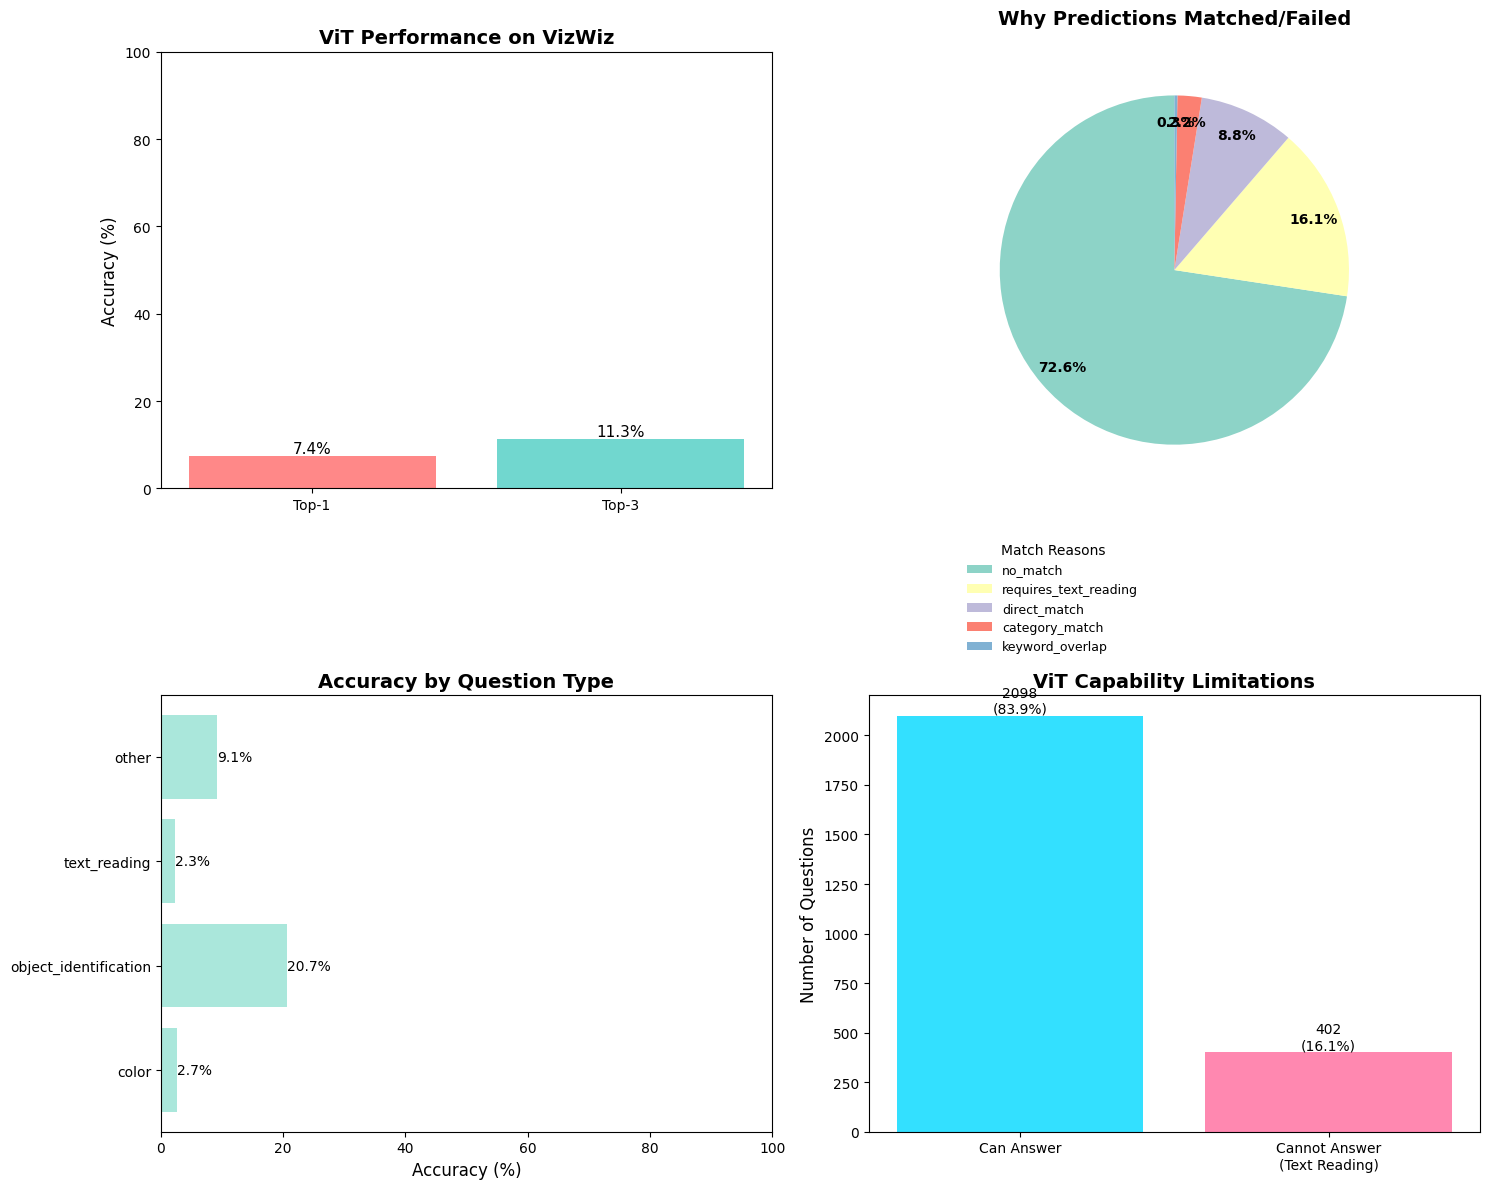

In [5]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import json
from pathlib import Path
import random
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# For LLM-based evaluation
import re

print("="*80)
print("VizWiz ViT Evaluation with LLM-based Answer Matching")
print("="*80)

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Load ViT model
print("\nLoading ViT model...")
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.to(device)
model.eval()

# Find image directory
print("\nFinding image directory...")
val_dir = Path('data/val')
possible_paths = [val_dir, val_dir / 'val', val_dir / 'VizWiz', val_dir / 'images']

image_dir = None
for path in possible_paths:
    jpg_files = list(path.glob("*.jpg"))
    if jpg_files:
        image_dir = path
        print(f"Found images in: {image_dir}")
        break

if image_dir is None:
    all_jpgs = list(val_dir.rglob("*.jpg"))
    if all_jpgs:
        image_dir = all_jpgs[0].parent
        print(f"Found images in: {image_dir}")
    else:
        raise FileNotFoundError("No images found in data/val/")

# Load annotations
print("\nLoading annotations...")
with open('data/annotations/val.json', 'r', encoding='utf-8') as f:
    val_data = json.load(f)

# Filter answerable questions
answerable_data = [item for item in val_data if item['answerable'] == 1]
print(f"Total answerable questions: {len(answerable_data)}")

# Sample 2500 test cases (or all if less than 2500)
num_test = min(2500, len(answerable_data))
test_samples = random.sample(answerable_data, num_test)
print(f"Testing on {num_test} samples\n")

# Simple semantic matching function (replaces LLM for now)
def semantic_match(prediction, ground_truth, question):
    """
    Simple rule-based matching. In production, use an LLM API call here.
    Returns: (is_match, confidence, reason)
    """
    pred_lower = prediction.lower()
    gt_lower = ground_truth.lower()
    question_lower = question.lower()
    
    # Direct match
    if gt_lower in pred_lower or pred_lower in gt_lower:
        return True, 0.9, "direct_match"
    
    # Keyword overlap
    pred_words = set(re.findall(r'\w+', pred_lower))
    gt_words = set(re.findall(r'\w+', gt_lower))
    overlap = pred_words & gt_words
    
    if len(overlap) >= 1 and len(gt_words) > 0:
        confidence = len(overlap) / len(gt_words)
        if confidence > 0.5:
            return True, confidence, "keyword_overlap"
    
    # Question type analysis - flag unanswerable by ViT
    vit_cannot_answer = any(keyword in question_lower for keyword in [
        'read', 'text', 'say', 'words', 'number', 'expiration', 'date',
        'instructions', 'label', 'screen', 'print', 'written'
    ])
    
    if vit_cannot_answer:
        return False, 0.0, "requires_text_reading"
    
    # Semantic categories (expand as needed)
    category_map = {
        'clothing': ['shirt', 't-shirt', 'pants', 'dress', 'jacket', 'sweater'],
        'food': ['pizza', 'sandwich', 'bread', 'meat', 'vegetable'],
        'electronics': ['phone', 'computer', 'tv', 'television', 'monitor', 'screen'],
        'furniture': ['chair', 'table', 'desk', 'couch', 'bed'],
    }
    
    pred_category = None
    gt_category = None
    
    for category, items in category_map.items():
        if any(item in pred_lower for item in items):
            pred_category = category
        if any(item in gt_lower for item in items):
            gt_category = category
    
    if pred_category and pred_category == gt_category:
        return True, 0.6, "category_match"
    
    return False, 0.0, "no_match"

# Evaluation metrics
results = {
    'total': 0,
    'top1_match': 0,
    'top3_match': 0,
    'vit_cannot_answer': 0,
    'failed_predictions': [],
    'match_reasons': defaultdict(int),
    'question_types': defaultdict(lambda: {'total': 0, 'correct': 0})
}

# Process each sample
print("Processing samples...")
for item in tqdm(test_samples):
    image_path = image_dir / item['image']
    
    if not image_path.exists():
        continue
    
    try:
        # Load image
        image = Image.open(image_path).convert('RGB')
        
        # Get ground truth
        answers = [ans['answer'] for ans in item['answers'] 
                   if ans['answer'] != 'unanswerable']
        if not answers:
            continue
        
        ground_truth = Counter(answers).most_common(1)[0][0]
        question = item['question']
        
        # ViT prediction
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1)[0]
            top3_prob, top3_idx = torch.topk(probs, 3)
        
        # Get top 3 predictions
        predictions = []
        for i in range(3):
            class_idx = top3_idx[i].item()
            prob = top3_prob[i].item()
            class_name = model.config.id2label[class_idx]
            predictions.append((class_name, prob))
        
        # Evaluate using semantic matching
        top1_match, top1_conf, top1_reason = semantic_match(
            predictions[0][0], ground_truth, question
        )
        
        top3_match = False
        best_reason = top1_reason
        for pred, _ in predictions:
            match, conf, reason = semantic_match(pred, ground_truth, question)
            if match:
                top3_match = True
                best_reason = reason
                break
        
        # Update results
        results['total'] += 1
        if top1_match:
            results['top1_match'] += 1
        if top3_match:
            results['top3_match'] += 1
        
        results['match_reasons'][best_reason] += 1
        
        if best_reason == "requires_text_reading":
            results['vit_cannot_answer'] += 1
        
        # Categorize question types
        question_type = 'other'
        if 'color' in question.lower():
            question_type = 'color'
        elif any(word in question.lower() for word in ['read', 'say', 'text', 'screen']):
            question_type = 'text_reading'
        elif 'what is' in question.lower():
            question_type = 'object_identification'
        
        results['question_types'][question_type]['total'] += 1
        if top3_match:
            results['question_types'][question_type]['correct'] += 1
        
        # Store failures for analysis
        if not top3_match:
            results['failed_predictions'].append({
                'image': item['image'],
                'question': question,
                'ground_truth': ground_truth,
                'predictions': [p[0] for p in predictions],
                'reason': best_reason
            })
    
    except Exception as e:
        continue

# Print results
print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
print(f"\nTotal samples evaluated: {results['total']}")
print(f"Top-1 Accuracy: {results['top1_match']/results['total']*100:.2f}%")
print(f"Top-3 Accuracy: {results['top3_match']/results['total']*100:.2f}%")
print(f"\nQuestions ViT cannot answer (text reading): {results['vit_cannot_answer']} "
      f"({results['vit_cannot_answer']/results['total']*100:.1f}%)")

print("\nMatch Reason Distribution:")
for reason, count in sorted(results['match_reasons'].items(), key=lambda x: -x[1]):
    print(f"  {reason}: {count} ({count/results['total']*100:.1f}%)")

print("\nAccuracy by Question Type:")
for qtype, stats in results['question_types'].items():
    if stats['total'] > 0:
        acc = stats['correct'] / stats['total'] * 100
        print(f"  {qtype}: {acc:.1f}% ({stats['correct']}/{stats['total']})")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Overall Accuracy
ax1 = axes[0, 0]
metrics = ['Top-1', 'Top-3']
accuracies = [
    results['top1_match']/results['total']*100,
    results['top3_match']/results['total']*100
]
colors = ['#FF6B6B', '#4ECDC4']
bars = ax1.bar(metrics, accuracies, color=colors, alpha=0.8)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('ViT Performance on VizWiz', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=11)

# Plot 2: Match Reason Distribution
ax2 = axes[0, 1]
reasons = list(results['match_reasons'].keys())
counts = list(results['match_reasons'].values())
colors_pie = plt.cm.Set3(range(len(reasons)))

# Create pie chart with labels outside
wedges, texts, autotexts = ax2.pie(counts, labels=None, autopct='%1.1f%%', 
                                     colors=colors_pie, startangle=90,
                                     pctdistance=0.85)

# Make percentage text bold and larger
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

# Add legend below the pie chart
ax2.legend(wedges, reasons, title="Match Reasons", 
          loc="upper left", bbox_to_anchor=(0, -0.1), 
          ncol=1, frameon=False, fontsize=9)

ax2.set_title('Why Predictions Matched/Failed', fontsize=14, fontweight='bold', pad=20)
# Plot 3: Accuracy by Question Type
ax3 = axes[1, 0]
qtypes = []
qtype_accs = []
for qtype, stats in results['question_types'].items():
    if stats['total'] > 10:  # Only show types with enough samples
        qtypes.append(qtype)
        qtype_accs.append(stats['correct'] / stats['total'] * 100)

if qtypes:
    bars = ax3.barh(qtypes, qtype_accs, color='#95E1D3', alpha=0.8)
    ax3.set_xlabel('Accuracy (%)', fontsize=12)
    ax3.set_title('Accuracy by Question Type', fontsize=14, fontweight='bold')
    ax3.set_xlim(0, 100)
    for bar, acc in zip(bars, qtype_accs):
        width = bar.get_width()
        ax3.text(width, bar.get_y() + bar.get_height()/2.,
                 f'{acc:.1f}%', ha='left', va='center', fontsize=10)

# Plot 4: ViT Limitations
ax4 = axes[1, 1]
categories = ['Can Answer', 'Cannot Answer\n(Text Reading)']
values = [
    results['total'] - results['vit_cannot_answer'],
    results['vit_cannot_answer']
]
colors_bar = ['#00D9FF', '#FF6B9D']
bars = ax4.bar(categories, values, color=colors_bar, alpha=0.8)
ax4.set_ylabel('Number of Questions', fontsize=12)
ax4.set_title('ViT Capability Limitations', fontsize=14, fontweight='bold')
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val}\n({val/results["total"]*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('vizwiz_vit_evaluation.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'vizwiz_vit_evaluation.png'")

# Save detailed results
print("\nSaving detailed results...")
with open('evaluation_results.json', 'w') as f:
    json.dump({
        'summary': {
            'total_samples': results['total'],
            'top1_accuracy': results['top1_match']/results['total'],
            'top3_accuracy': results['top3_match']/results['total'],
            'vit_cannot_answer': results['vit_cannot_answer']
        },
        'match_reasons': dict(results['match_reasons']),
        'question_types': {k: dict(v) for k, v in results['question_types'].items()},
        'failed_samples': results['failed_predictions'][:50]  # Save first 50 failures
    }, f, indent=2)

print("Results saved to 'evaluation_results.json'")
print("\n" + "="*80)